# Лаборатнорная работа

Цель - провести экспериментальное исследование и анализ алгоритма WA* с разными значениями параматера w (фактор субоптимальности). 
Нам нужен ответ на вопрос насколько сильно мы теряем в качестве решения (длине пути) и при этом приобретаем в вычислительной эффективности (решение ищется быстрее).

# Библиотеки

In [1]:
from heapq import heappop, heappush, heapify
import math
from collections import defaultdict
from tqdm import tqdm

import random
import traceback
#import heapq
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

# Карты

In [2]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray, name: str = None):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._name = name
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 8-connected, allowing moves only in diagonal directions
        without corner cutting.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        # cardinal_moves
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        # diagonal_moves
        delta = ((1, 1), (1, -1), (-1, 1), (-1, -1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if (self.in_bounds(ni, nj)
                    and self.traversable(ni, nj)
                    and self.traversable(i + dx, j)
                    and self.traversable(i, j + dy)):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:
def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move! ONLY cardinal moves are supported.")

# Чтение карт и тестов


In [4]:
def read_map_from_file(filename: str) -> "Map":
    f = open(filename, 'r')
    lines = f.readlines()
    height = int(lines[1].split()[1])
    width = int(lines[2].split()[1])
    cells = np.array([[0 if char == "." else 1 for char in line.rstrip()] for line in lines[4:]], dtype=np.int8,)
    f.close()
    cells.shape == (height, width)
    return Map(cells, name=filename.split('/')[-1].split('.')[0])

In [5]:
class Script:
    def __init__(self, 
    map_name: str,
    width: int,
    height: int,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    goal_length: float):
        
        self.map_name = map_name
        self.width = width
        self.height = height
        self.start_i, self.start_j = start_i, start_j
        self.goal_i, self.goal_j = goal_i, goal_j
        self.goal_length = goal_length
    

In [6]:
def read_test_file(filename: str) -> List["Script"]:
    f = open(filename, 'r')
    lines = f.readlines()
    scripts = []
    for line in lines[1:]:
        map_name = line.split()[1]
        width, height, start_j, start_i, goal_j, goal_i = map(int, line.split()[2: 8])
        goal_length = float(line.split()[8])
        scripts.append(Script(map_name, width, height, start_i, start_j, goal_i, goal_j, goal_length))
    f.close()
    return scripts

# Ноды

In [7]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i == other.i) and (self.j == other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

# Метрики

In [8]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    dx = abs(j1 - j2)
    dy = abs(i1 - i2)
    return math.sqrt(2) * min(dx, dy) + abs(dx - dy)


# Алгоритмы

Были взяты:
1) алгоритм A* без перераскрытий из лабораторной №3
2) алгортим WA* c параметрами w равными 1.05, 1.5, 2, 3, 5

In [9]:
class SearchTreePQD_A:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return True if len(self._open) == 0 else False

    
    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)
        
        
    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        if self.open_is_empty():
            return None
        goal_node = heappop(self._open)
        while self.was_expanded(goal_node):
            self._enc_open_duplicates += 1
            goal_node = heappop(self._open)
        return goal_node
    
    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = True

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return self._closed.get(item, False)

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return list(self._closed.keys())

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

In [17]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD_A],
    w = None
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0
    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j, g=0, h=0) # goal_node, h = 0 becuase it's last node
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        curr_node = ast.get_best_node_from_open()
        if curr_node is None:
            break
        if goal_node == curr_node:
            return True, curr_node, steps, len(ast), ast.opened, ast.expanded
        ast.add_to_closed(curr_node)
        for element in task_map.get_neighbors(curr_node.i, curr_node.j):
            expansion_cost = compute_cost(curr_node.i, curr_node.j, element[0], element[1])
            next_node = Node(element[0], element[1],
                             g=curr_node.g + expansion_cost,
                             h=heuristic_func(element[0], element[1], goal_i, goal_j),
                             parent=curr_node)
            if ast.was_expanded(next_node):
                continue
            ast.add_to_open(next_node)
        steps += 1
    
    return False, None, steps, len(ast), None, ast.expanded

In [18]:
def wastar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD_A],
    w: float = 1
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0
    start_node = Node(start_i, start_j, g=0, h=w * heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j, g=0, h=0) # goal_node, h = 0 becuase it's last node
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        curr_node = ast.get_best_node_from_open()
        if curr_node is None:
            break
        if goal_node == curr_node:
            return True, curr_node, steps, len(ast), ast.opened, ast.expanded
        ast.add_to_closed(curr_node)
        for element in task_map.get_neighbors(curr_node.i, curr_node.j):
            expansion_cost = compute_cost(curr_node.i, curr_node.j, element[0], element[1])
            next_node = Node(element[0], element[1],
                             g=curr_node.g + expansion_cost,
                             h=w * heuristic_func(element[0], element[1], goal_i, goal_j),
                             parent=curr_node)
            if ast.was_expanded(next_node):
                continue
            ast.add_to_open(next_node)
        steps += 1
    
    return False, None, steps, len(ast), None, ast.expanded

# Тесты

Будем проводить исследования на картах
1) Карта Милана (Milan_1_256)
2) карта из baldur's gate 2 (AR0705SR)
3) карта из dungeons and dragons (den011d)

Используемая эвристика: octile_distance

Используемые алгоритмы: A* и WA* с разичными параметрами w равными
- w = 1.05
- w = 1.5
- w = 2
- w = 3
- w = 5

In [23]:
def tested_script(
        map: Map,
        script: Script,
        algorithm: Callable,
        search_tree,
        heuristic_func: Optional[Callable] = None,
        **kwargs):
    result = algorithm(
        task_map=map,
        start_i=script.start_i,
        start_j=script.start_j,
        goal_i=script.goal_i,
        goal_j=script.goal_j,
        heuristic_func=heuristic_func,
        search_tree=search_tree,
        **kwargs
    )
    
    path_found = result[0]
    length = result[1].g if path_found else None
    counted_steps = result[2]
    number_of_expansions = len(result[-1])
    # check correctness using script length infromation
    correctness = False if not path_found else (abs(length - script.goal_length) < 1e-6)
    return correctness, length, counted_steps, number_of_expansions

In [24]:
city_map = read_map_from_file('data/Milan256/Milan_1_256.map')
city_scripts = np.array(read_test_file('data/Milan256/Milan_1_256.map.scen'))

#city_map = read_map_from_file('data/Milan/Milan_1_512.map')
#city_scripts = np.array(read_test_file('data/Milan/Milan_1_512.map.scen'))

bg2_map = read_map_from_file('data/Baldurs_gate_2/AR0705SR.map')
bg2_scripts = np.array(read_test_file('data/Baldurs_gate_2/AR0705SR.map.scen'))

dend_map = read_map_from_file('data/dend/den011d.map')
dend_scripts = np.array(read_test_file('data/dend/den011d.map.scen'))

In [25]:
amount_scripts = 100
city_scripts = np.random.choice(a=city_scripts, size=amount_scripts)
bg2_scripts = np.random.choice(a=bg2_scripts, size=amount_scripts)
dend_scripts = np.random.choice(a=dend_scripts, size=amount_scripts)

testing_samples = [(dend_map, dend_scripts), (city_map, city_scripts), (bg2_map, bg2_scripts)]

testing_confingurations = (
    ('A*', astar, SearchTreePQD_A, octile_distance, None),
    ('WA*(1.05)', wastar, SearchTreePQD_A, octile_distance, 1.05),
    ('WA*(1.5)', wastar, SearchTreePQD_A, octile_distance, 1.5),
    ('WA*(2)', wastar, SearchTreePQD_A, octile_distance, 2),
    ('WA*(3)', wastar, SearchTreePQD_A, octile_distance, 3),
    ('WA*(5)', wastar, SearchTreePQD_A, octile_distance, 5),
)

### Тесты в следующей ячейке прошли за x минут

In [26]:
correctness = defaultdict(lambda: defaultdict(lambda: []))
length_percentage_of_optimal = defaultdict(lambda: defaultdict(lambda: []))
steps = defaultdict(lambda: defaultdict(lambda: []))
expansions = defaultdict(lambda: defaultdict(lambda: []))

for (testing_map, script_list) in testing_samples:
    print(f"Testings on {testing_map._name}")
    for script in tqdm(script_list):
        for (algorithm_name, algorithm, search_tree, heuristic_func, w) in testing_confingurations:
            result = tested_script(testing_map, script, algorithm, search_tree, heuristic_func, w=w)
            # result returns: correctness, length, steps, num of expansions
            map_name = testing_map._name
            correctness[algorithm_name][map_name].append(result[0])
            length_percentage_of_optimal[algorithm_name][map_name].append(result[1] / script.goal_length)
            steps[algorithm_name][map_name].append(result[2])
            expansions[algorithm_name][map_name].append(result[3])

Testings on den011d


100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.84it/s]


Testings on Milan_1_256


100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


Testings on AR0705SR


100%|█████████████████████████████████████████| 100/100 [07:52<00:00,  4.73s/it]


# Результаты

## Корректность

In [32]:
alg_names = [elem[0] for elem in testing_confingurations]
maps_names = [elem[0]._name for elem in testing_samples]

for alg_name in alg_names:
    print(f"Algorithm: {alg_name}")
    for map_name in maps_names:
        print(f"\tMap: {map_name}:", end=" ")
        result = np.sum(np.array(correctness[alg_name][map_name]) == 1)
        print(f"{result}/{amount_scripts}")
       

Algorithm: A*
	Map: den011d: 100/100
	Map: Milan_1_256: 100/100
	Map: AR0705SR: 100/100
Algorithm: WA*(1.05)
	Map: den011d: 62/100
	Map: Milan_1_256: 64/100
	Map: AR0705SR: 50/100
Algorithm: WA*(1.5)
	Map: den011d: 26/100
	Map: Milan_1_256: 37/100
	Map: AR0705SR: 24/100
Algorithm: WA*(2)
	Map: den011d: 22/100
	Map: Milan_1_256: 32/100
	Map: AR0705SR: 20/100
Algorithm: WA*(3)
	Map: den011d: 18/100
	Map: Milan_1_256: 25/100
	Map: AR0705SR: 8/100
Algorithm: WA*(5)
	Map: den011d: 17/100
	Map: Milan_1_256: 25/100
	Map: AR0705SR: 8/100


## Кол-во итераций по алгоритмам

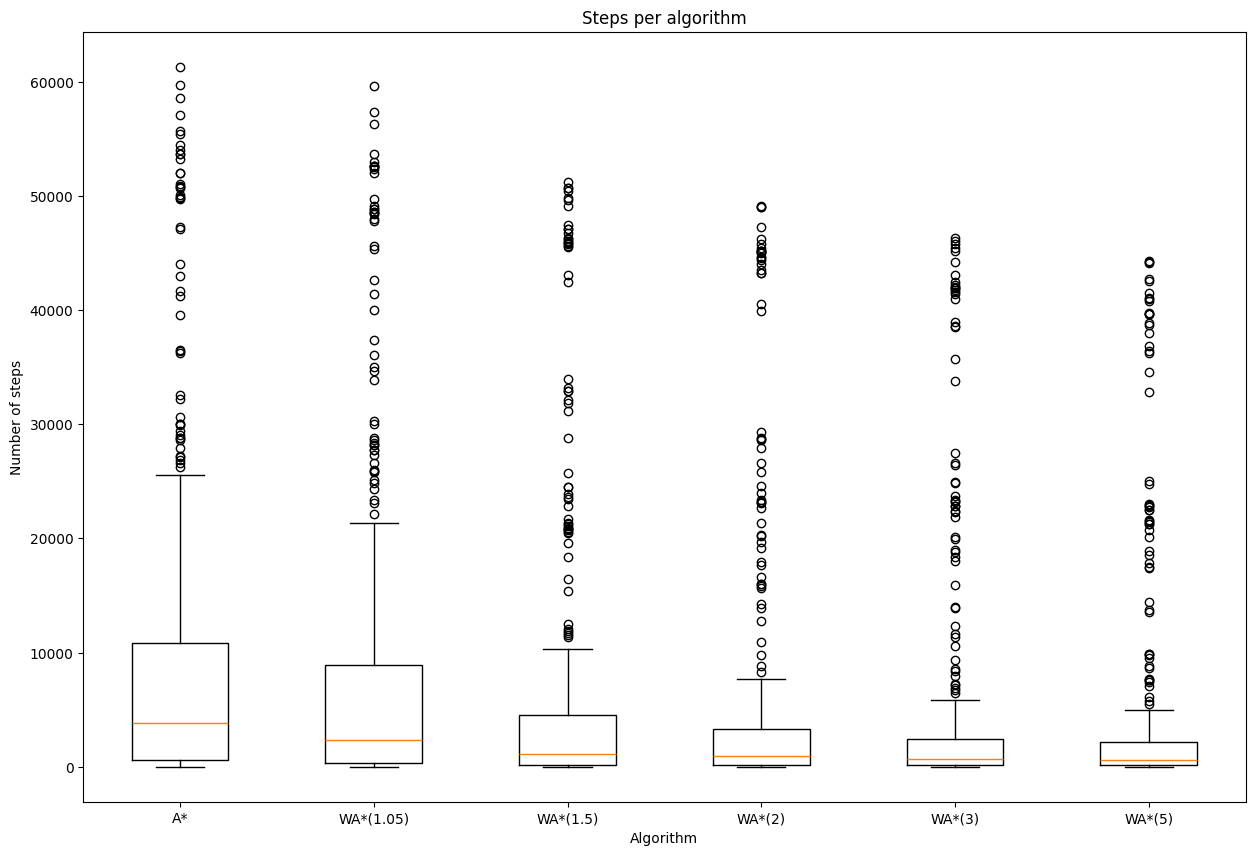

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlabel('Algorithm')
plt.ylabel('Number of steps')
plt.title("Steps per algorithm")
ax.boxplot([np.hstack(np.array([steps[algorithm][map_name] for map_name in maps_names])) for algorithm in alg_names], tick_labels=alg_names)
plt.show()

## Кол-во итераций по картам

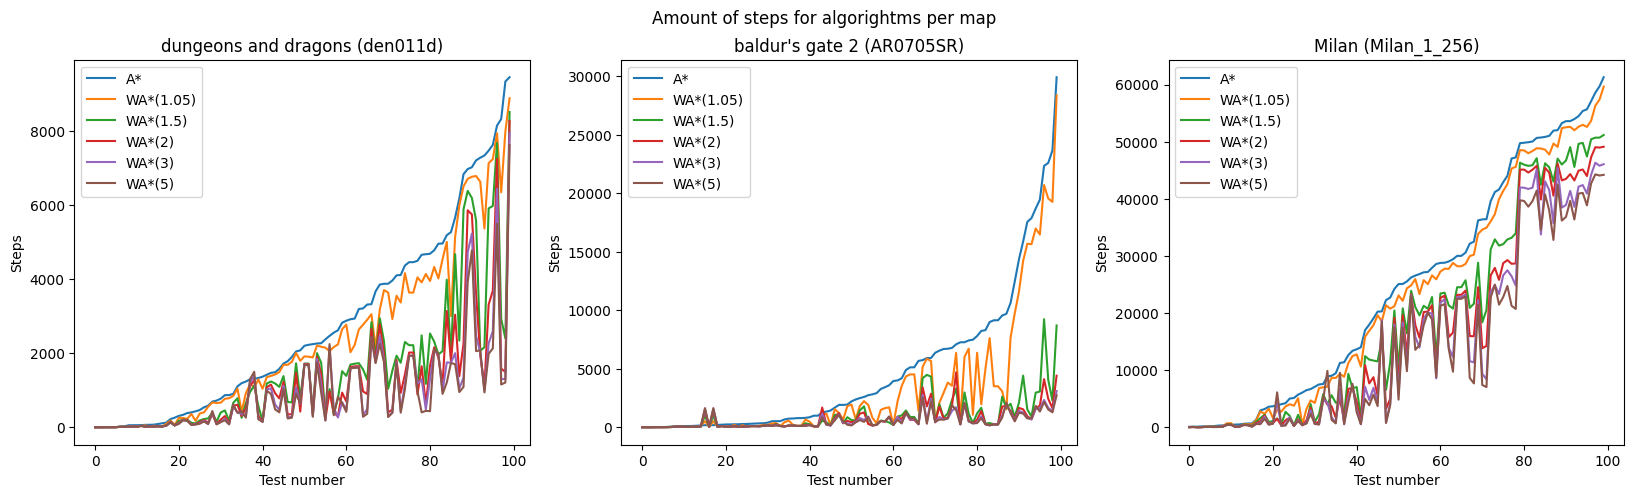

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Amount of steps for algorightms per map')

ax1.set_title("dungeons and dragons (den011d)")
ax2.set_title("baldur's gate 2 (AR0705SR)")
ax3.set_title("Milan (Milan_1_256)")

# Номер теста: по возрастанию кол-во шагов у алгоритма A*
ax1.set(xlabel='Test number', ylabel='Steps')
ax2.set(xlabel='Test number', ylabel='Steps')
ax3.set(xlabel='Test number', ylabel='Steps')

j = 0
for ax in ax1, ax2, ax3:
    curr_map = maps_names[j]
    astar_steps = np.array(steps['A*'][curr_map])
    sort_index = np.argsort(astar_steps)
    for alg in alg_names:
        alg_steps = np.hstack(np.array([(steps[alg][curr_map])]))[sort_index]
        ax.plot(range(100), alg_steps)
    j += 1

ax1.legend(alg_names)
ax2.legend(alg_names)
ax3.legend(alg_names)

## Кол-во раскрытий по картам

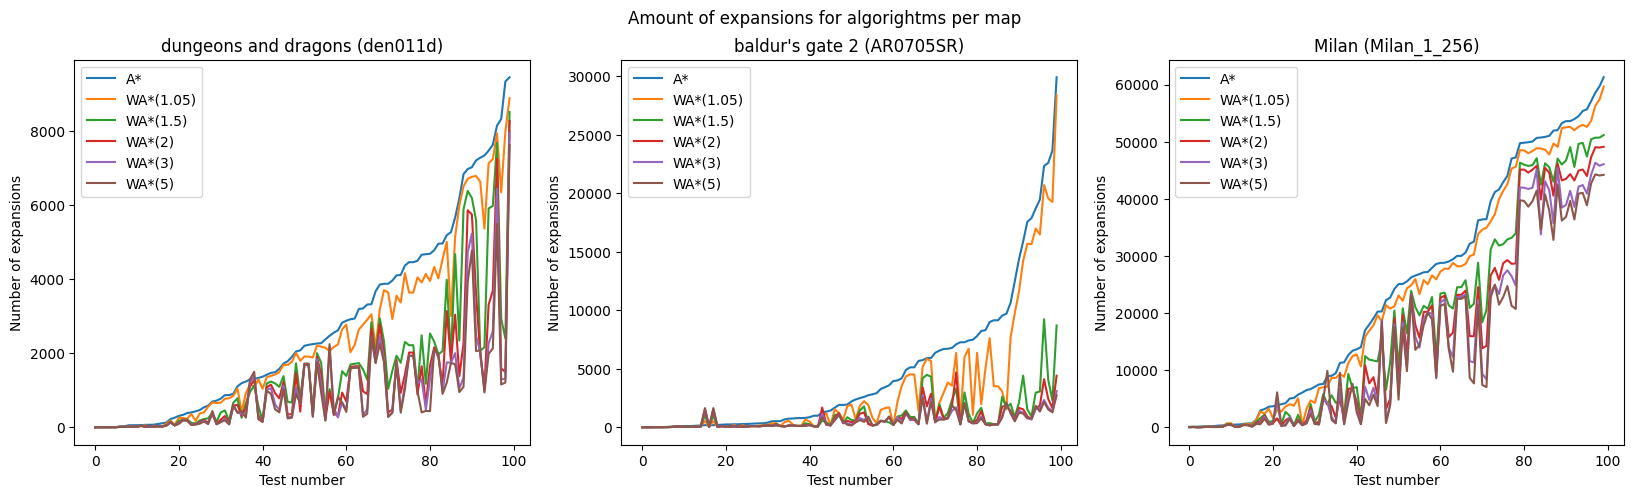

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Amount of expansions for algorightms per map')

ax1.set_title("dungeons and dragons (den011d)")
ax2.set_title("baldur's gate 2 (AR0705SR)")
ax3.set_title("Milan (Milan_1_256)")

# Номер теста: по возрастанию кол-во раскрытий у алгоритма A*
ax1.set(xlabel='Test number', ylabel='Number of expansions')
ax2.set(xlabel='Test number', ylabel='Number of expansions')
ax3.set(xlabel='Test number', ylabel='Number of expansions')

j = 0
for ax in ax1, ax2, ax3:
    curr_map = maps_names[j]
    astar_steps = np.array(expansions['A*'][curr_map])
    sort_index = np.argsort(astar_steps)
    for alg in alg_names:
        alg_exps = np.hstack(np.array([(expansions[alg][curr_map])]))[sort_index]
        ax.plot(range(100), alg_exps)
    j += 1

ax1.legend(alg_names)
ax2.legend(alg_names)
ax3.legend(alg_names)

## На сколько процентов (в среднем) полученный путь длинее оптимального

[1.3981971136445281e-10, 0.0026670066421070615, 0.024249376648994625, 0.034329991109571134, 0.05225732480936318, 0.08403439542169755]


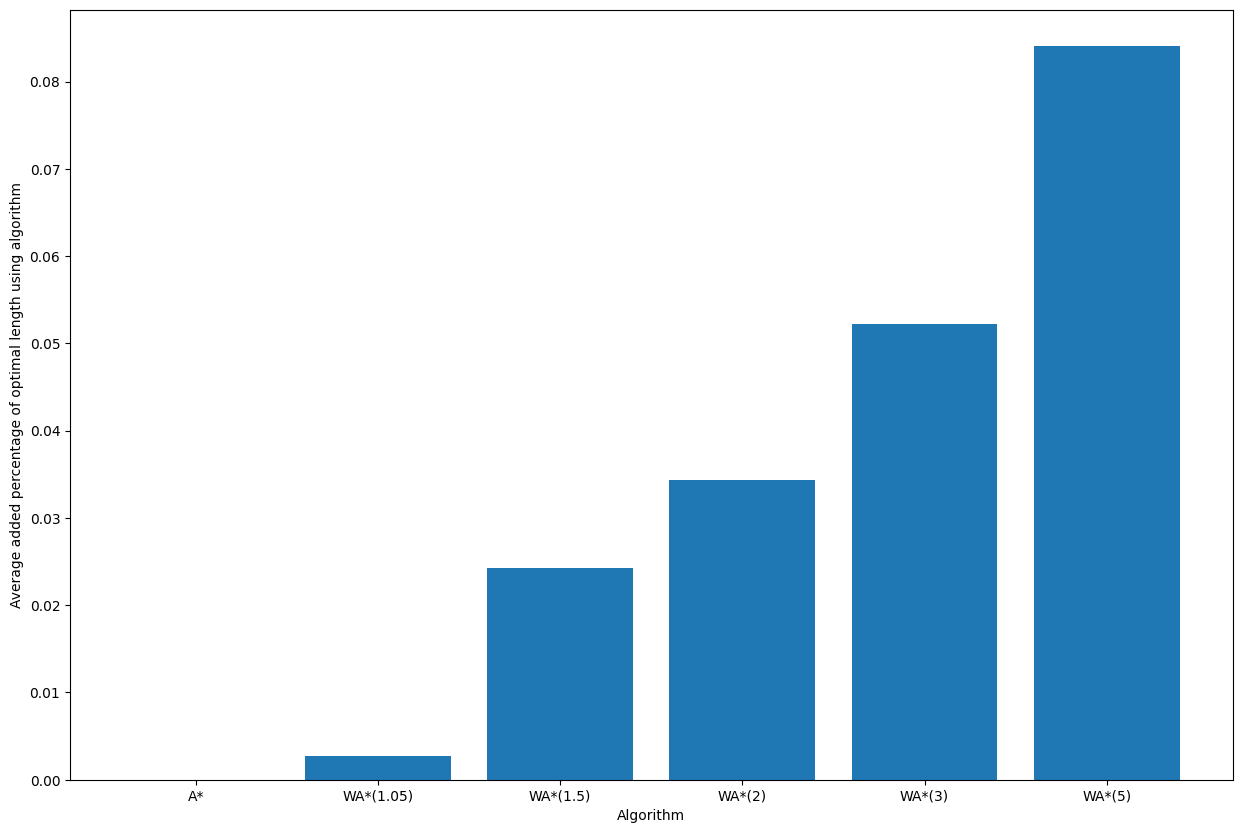

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xlabel('Algorithm')
plt.ylabel("Average added percentage of optimal length using algorithm")
ax.bar(x=alg_names, height=[np.mean([length_percentage_of_optimal[el][map_name] for map_name in maps_names]) - 1 for el in alg_names])
print([np.mean([length_percentage_of_optimal[el][map_name] for map_name in maps_names]) - 1 for el in alg_names])

# Выводы

- A* всегда находит оптимальный путь в отличие от WA*
- Чем меньше параметр w в алгоитме WA*, тем ближе решение к оптимальному
- Чем меньше параметр w в алгоитме WA*, тем меньше скорость нахождения решения
- Полезно рассматривать различные значения w и выбирать то, которое больше подходит под корнкретную задачу (Например в задачах, где критически важно выбрать максимально близкий к оптимальному путь, лучше взять w близкий к 1, а в задачх, где важна только скорость нахождения решения, можно брать w побольше)